## Imports

In [1]:
import math 
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3)

20

## Graph

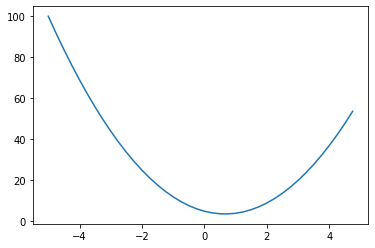

In [4]:
data = np.arange(-5,5,0.25)
ys = f(data)
plt.plot(data, ys)

## Definition of a derivative

A function of a real variable f(x) is ***differentiable*** at a point *a* of its domain, if its domain contains an open interval ***I*** containing *a*, and the limit exists.

![limit](https://wikimedia.org/api/rest_v1/media/math/render/svg/aae79a56cdcbc44af1612a50f06169b07f02cbf3)

In other words...

If you take a data point, *x*, and bump it up by a very small number, *h* , how does the function respond? With what sensitivity does it respond? What is the slope at that point? Does the function go up or does it go down and by how much?


By taking the difference in rises (Δ) and normalizing by h, you will get the slope at that exact point. This resulting slope will tell you if the function is increasing or not.

Lets take a look at an example.

In [5]:
# Numerical approximation of the slope
h = 0.001
broken_h = 0.0000000000000001   # we have to make h a very, very small number to converge to the exact amount
                                # although, we will see that that adding too many zeros will result in a 
                                # floating point arithmetic problem
x = 3.0
print(f'f(x): {f(x)}')
print(f'f(x + h): {f(x + h)}')  # slightly nudge x towards a positive direction, how is the function going to respond?
print(f'f(x + h) - f(x): {f(x + h) - f(x)}')  # this is how much the function responded in the positive direction
print(f'f(x + h) - f(x) / h: {(f(x + h) - f(x)) / h}')  # now we have to normalize by the run (remember: rise over run) to get the SLOPE
(f(x + broken_h) - f(x)) / broken_h # floating point arithmetic problem, there is a finite amount of computer memory to represent these numbers

f(x): 20.0
f(x + h): 20.014003000000002
f(x + h) - f(x): 0.01400300000000243
f(x + h) - f(x) / h: 14.00300000000243


0.0

Let's say x = -3.0.

What would you expect for the slope? Will it be negative or positive?

In [6]:
x = -3.0
(f(x + h) - f(x)) / h

-21.996999999998934

As we can see from the result above, if we slightly go in the positive direction at x, the function would actually go down. 

So that tells us the slope will be negative.

## Minigrad

In [7]:
class Value():

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'
  
  def __add__(self, other):       # Internally, a.__add__(b) is being called
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):       # Internally, a.__mul__(b) is being called
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += out.grad * other.data
      other.grad += out.grad * self.data
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():  # self**other
      self.grad += other * self.data ** (other - 1) * out.grad
    out._backward = _backward
    
    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __radd__(self, other):
    return self + other

  def __rsub__(self, other): # other - self
        return other + (-self)
        
  def __truediv__(self, other): # self / other
    return self * other**-1
  
  def __neg__(self):  # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def tanh(self): # tanh(self.data)
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):  # exp(self.data)
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
  
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [8]:
a = Value(2.0)
b = Value(4.0)
e = (2*a).exp()
e.data

54.598150033144236

In [9]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

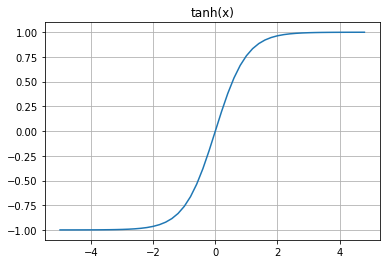

In [10]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid(); plt.title('tanh(x)');

In [11]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

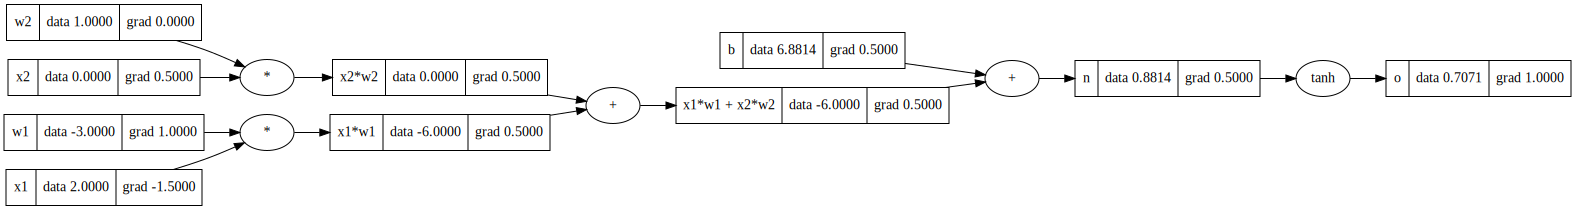

In [12]:
draw_dot(o)

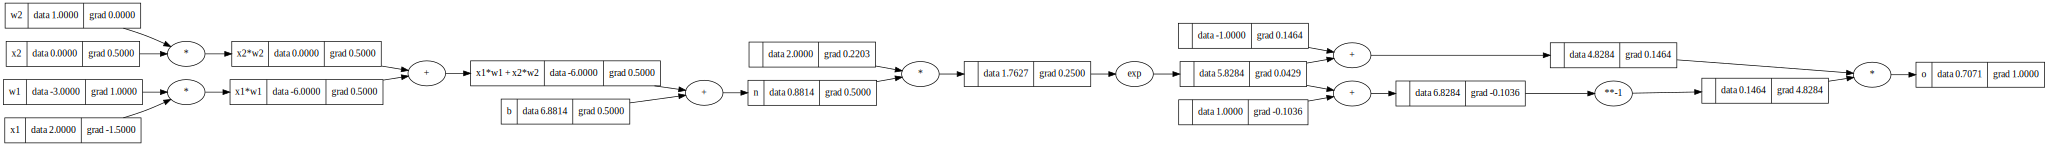

In [13]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# --------------
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = 'o'
# --------------
o.backward()
draw_dot(o)

## Implementing with PyTorch API

In [14]:
import torch

In [15]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
---
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


In [16]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), start=self.b) 
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

Let's try to implement this NN

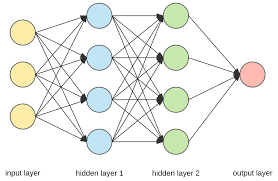

In [17]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.597675821299012)

In [18]:
xs = [
  [2.0, 3.0, -1.0], # we want 1.0 
  [3.0, -1.0, 0.5], # we want -1.0
  [0.5, 1.0, 1.0],  # -1.0 but got 
  [1.0, 1.0, -1.0], # 1.0 but got 
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

**Question**: Now how do we tune the weights to better predict the desired targets?

**Solution**: The trick used in deep learning to achieve this is to calculate a single number that somehow measures the total *performance* of your neural net... 

**And we call this single number the _loss_.**

Right now we have the intuitive sense that it's not performing very well because we're not very much close to our desired targets, so the loss will be high and we'll want to minimize the loss.

To minimize the loss we're going to implement the _**mean square error loss**_ 

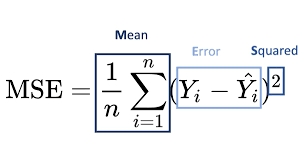


In [19]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)
  

0 5.186151878842725
1 1.1577520378551518
2 0.4853040608848852
3 0.07845575351340887
4 0.06403108181881197
5 0.05448648844308707
6 0.04753894330256135
7 0.04219950704307864
8 0.03794675621305142
9 0.03447108431171536
10 0.03157373354628845
11 0.029119906178707633
12 0.027014368224961467
13 0.02518766103020116
14 0.02358780719480041
15 0.022175073770025595
16 0.02091853500078443
17 0.01979374322020657
18 0.018781107907527177
19 0.017864741564170984


This value also has a grad because of the backwards pass.

And so wee see that because this gradient here on this particular weight on this particular neuron of this particular layer is **negative**.

We see that its **influence on the loss is also negative** so slightly *increasing* this particular weight of this neuron of this layer would make the loss _**go down**_

And we actually have this information for every single one of our neurons and all their parameters

In [ ]:
draw_dot(loss)

Question: So, previously we looked at the `draw_dot` of a single neuron forward pass and that was already a large expression **but what is this expression above?**

Solution: We actually forwarded every one of those four examples (`xs`) and then we have the loss on top of them with the mean squared error. 

===============================================================================

And now this loss will now backpropagate through all the four forward passes all the way through every single intermediate value of the neural net, all the way back to the parameters of the weights, which are the inputs.

For reference: 
```
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
```
These weight parameters here below are inputs to this neural net.
```
self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
self.b = Value(random.uniform(-1,1))
```
And these scalars here below are inputs to the neural neural net.
You'll see on the graph that these values have gradients as well. The thing is these gradients on the **input data** (don't confuse with the weight params) are not that useful to us and thats because the input daya is not changeable, **it's a given to the problem**. 
```
xs = [
  [2.0, 3.0, -1.0], 
  [3.0, -1.0, 0.5], 
  [0.5, 1.0, 1.0],  
  [1.0, 1.0, -1.0], 
]
```

For all 41 parameters, we want to change p data slightly according to the gradient information.

This tiny update is gradient descent. In gradient descent we are thinking of the gradient as a vector pointing in the direction of increased loss.

In other words, in gradient descent we are modifying `p.data` by a small step size in the direction of the gradient.